# Answering the Science Question

This notebook serves attemps to answer the science question _"How does using K-profile parameterization (KPP) compare with a turbulent kinetic enrgy scheme (GGL90) on the magnitude of mixing and intensity of stratification across the SLO bay."_ through the following methods:

1. Defining three points inside the bay, outside the bay and at the boundary to compare stratification and mixing across the bay and at different depths
   
2. Constructing Hovmoller diagrams for temperature and eddy viscosity

3. Finding the residuals from the Hovmoller diagrams to compare differences in magnitude

4. Creating a wind time series, and comparing it to eddy viscosity near the surface, and buoyancy frequency calculated for the top 5 meters

### First, import packages to re-create and visualize the model fields here:

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import gsw

### Then, re-create the model grid

In [19]:
diags_dir_kpp = '../data_kpp/'
diags_dir_tke = '../data_tke/'


delX = 1/480
delY = 1/480
xgOrigin = -120.9  
ygOrigin =  34.9 
n_rows = 180 
n_cols = 180 
n_depths = 100
tke_vars=7 
kpp_vars=5

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

### Mask wet cells

In [45]:
hfacC = np.fromfile('hFacC.data', dtype='>f4').reshape((n_depths, n_rows, n_cols))
surface_mask = hfacC[0, :, :] > 0
transect_mask = surface_mask[90, :]

### Define locations of profiles for plotting

In [47]:
lat_mid = 35.127
lon_mid = -120.7311

lat_out = 35.11
lon_out = -120.75

lat_in = 35.1425
lon_in = -120.7108

# find its location in the grid
dist_in = ((XC -lon_in)**2 + (YC -lat_in)**2)**0.5
row_in, col_in = np.where(dist_in==np.min(dist_in))

dist_mid = ((XC -lon_mid)**2 + (YC -lat_mid)**2)**0.5
row_mid, col_mid = np.where(dist_mid==np.min(dist_mid))

dist_out = ((XC -lon_out)**2 + (YC -lat_out)**2)**0.5
row_out, col_out = np.where(dist_out==np.min(dist_out))


[116]
[90]
[108]
[81]
[100]
[72]


### Create visualization for location of points

In [136]:
# Fike paths for January 25 for GGL90 and KPP
Jan_25_tke = '../data_tke/hourly_means.0002161800.data'
Jan_25_kpp = '../data_kpp/hourly_means.0002161800.data'

# Reading in data for eddy viscosity, temperature, and salinity for GGL90 model
tke_data = np.fromfile(Jan_25_tke, dtype='>f4')
tke_grid = tke_data.reshape((tke_vars, n_depths, n_rows, n_cols))
GGL90ArU_surface = tke_grid[6, 1, :, :]

# Mask
TKE_GGL90ArU_masked = np.ma.masked_where(surface_mask == 0, GGL90ArU_surface)

# Reading in data for eddy viscosity, temperature, and salinity for KPP model
kpp_data = np.fromfile(Jan_25_kpp, dtype='>f4')
kpp_grid = kpp_data.reshape((kpp_vars, n_depths, n_rows, n_cols))
KPPviscA_surface = kpp_grid[0, 1, :, :]
# Mask
KPP_viscA_masked = np.ma.masked_where(surface_mask == 0, KPPviscA_surface)



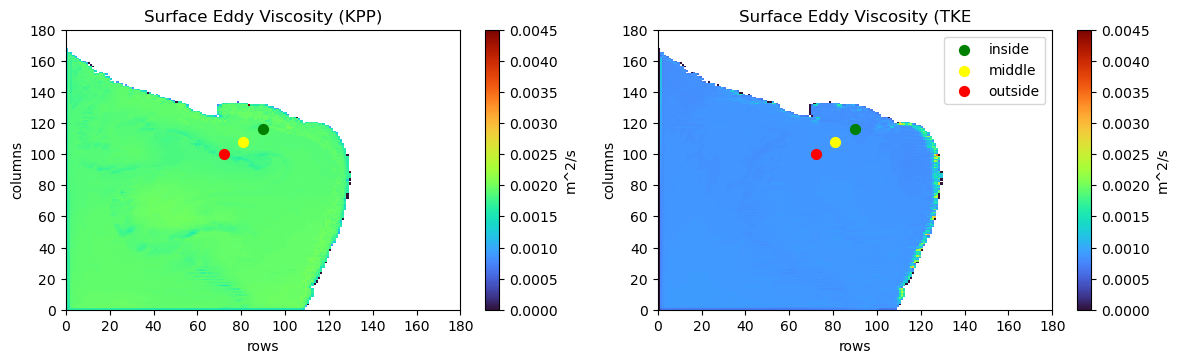

In [173]:
fig = plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
C = plt.pcolormesh(KPP_viscA_masked, cmap='turbo', vmin=0, vmax=0.0045)
plt.scatter(col_in, row_in, color='green', s=50, marker='o')
plt.scatter(col_mid, row_mid, color='yellow', s=50, marker='o')
plt.scatter(col_out, row_out, color='red', s=50, marker='o')
plt.title('Surface Eddy Viscosity (KPP)')
plt.xlabel('rows')
plt.ylabel('columns')
plt.colorbar(C, label = 'm^2/s')


plt.subplot(2,2,2)
C = plt.pcolormesh(TKE_GGL90ArU_masked, cmap='turbo', vmin=0, vmax=0.0045)
plt.scatter(col_in, row_in, color='green', s=50, marker='o', label = 'inside')
plt.scatter(col_mid, row_mid, color='yellow', s=50, marker='o', label = 'middle')
plt.scatter(col_out, row_out, color='red', s=50, marker='o', label = 'outside')
plt.title('Surface Eddy Viscosity (TKE')
plt.legend()
plt.xlabel('rows')
plt.ylabel('columns')
plt.colorbar(C, label = 'm^2/s')


### Create timeseries for each point including temperature, salinity, and eddy viscosity

In [155]:
tke_theta_timeseries_in = []
kpp_theta_timeseries_in = []
tke_salt_timeseries_in = []
kpp_salt_timeseries_in = []
tke_visc_timeseries_in = []
kpp_visc_timeseries_in = []

tke_theta_timeseries_mid = []
kpp_theta_timeseries_mid = []
tke_salt_timeseries_mid = []
kpp_salt_timeseries_mid = []
tke_visc_timeseries_mid = []
kpp_visc_timeseries_mid = []

tke_theta_timeseries_out = []
kpp_theta_timeseries_out = []
tke_salt_timeseries_out = []
kpp_salt_timeseries_out = []
tke_visc_timeseries_out = []
kpp_visc_timeseries_out = []

valid_days = []

days = list(range(1800000, 2299680, 360))

for day in days:

    #identify kpp file path
    kpp_data_path = os.path.join(diags_dir_kpp, f'hourly_means.{day:010d}.data')

    #define expected size and ignore deviations (theres a file somwhere that has a differnet size than the rest)
    expected_kpp_size = kpp_vars * n_rows * n_cols * n_depths
    kpp_data = np.fromfile(kpp_data_path, dtype='>f4')
    
    if kpp_data.size != expected_kpp_size:
        print('wrong file size :(')
        continue
        
    # make grid
    kpp_grid = kpp_data.reshape((kpp_vars, n_depths, n_rows, n_cols))
    
    # in
    KPPviscA_in = kpp_grid[0, :, row_in, col_in]
    KPPtheta_in = kpp_grid[1, :, row_in, col_in]
    KPPsalt_in = kpp_grid[2, :, row_in, col_in]
    
    # mid
    KPPviscA_mid = kpp_grid[0, :, row_mid, col_mid]
    KPPtheta_mid = kpp_grid[1, :, row_mid, col_mid]
    KPPsalt_mid = kpp_grid[2, :, row_mid, col_mid]
    
    # out
    KPPviscA_out = kpp_grid[0, :, row_out, col_out]
    KPPtheta_out = kpp_grid[1, :, row_out, col_out]
    KPPsalt_out = kpp_grid[2, :, row_out, col_out]

    # identify tke file path
    tke_data_path = os.path.join(diags_dir_tke, f'hourly_means.{day:010d}.data')

    #define expected size and ignore deviations (theres a file somwhere that has a differnet size than the rest)
    expected_tke_size = tke_vars * n_rows * n_cols * n_depths
    tke_data = np.fromfile(tke_data_path, dtype='>f4')
    
    if tke_data.size % expected_tke_size != 0:
        print(' file is the wrong size :(')
        continue
    #make grid
    tke_grid = tke_data.reshape((tke_vars, n_depths, n_rows, n_cols))
    
    # in
    GGL90ArU_in = tke_grid[6, :, row_in, col_in]
    GGL90theta_in = tke_grid[0, :, row_in, col_in]
    GGL90salt_in = tke_grid[1, :, row_in, col_in]
    
    # mid
    GGL90ArU_mid = tke_grid[6, :, row_mid, col_mid]
    GGL90theta_mid = tke_grid[0, :, row_mid, col_mid]
    GGL90salt_mid = tke_grid[1, :, row_mid, col_mid]
    
    # out
    GGL90ArU_out = tke_grid[6, :, row_out, col_out]
    GGL90theta_out = tke_grid[1, :, row_out, col_out]
    GGL90salt_out = tke_grid[2, :, row_out, col_out]

    # append to timeseries
    tke_visc_timeseries_in.append(GGL90ArU_in)
    kpp_visc_timeseries_in.append(KPPviscA_in)
    tke_theta_timeseries_in.append(GGL90theta_in)
    kpp_theta_timeseries_in.append(KPPtheta_in)
    tke_salt_timeseries_in.append(GGL90salt_in)
    kpp_salt_timeseries_in.append(KPPsalt_in)
    
    tke_visc_timeseries_mid.append(GGL90ArU_mid)
    kpp_visc_timeseries_mid.append(KPPviscA_mid)
    tke_theta_timeseries_mid.append(GGL90theta_mid)
    kpp_theta_timeseries_mid.append(KPPtheta_mid)
    tke_salt_timeseries_mid.append(GGL90salt_mid)
    kpp_salt_timeseries_mid.append(KPPsalt_mid)
    
    tke_visc_timeseries_out.append(GGL90ArU_out)
    kpp_visc_timeseries_out.append(KPPviscA_out)
    tke_theta_timeseries_out.append(GGL90theta_out)
    kpp_theta_timeseries_out.append(KPPtheta_out)
    tke_salt_timeseries_out.append(GGL90salt_out)
    kpp_salt_timeseries_out.append(KPPsalt_out)
    
    valid_days.append(day)

# create labels for x-axis
days_array = np.array(valid_days)
actual_days = days_array / 86400
whole_days = actual_days[actual_days % 1 == 0]

 file is the wrong size :(


### Create matrices for Hovmoller diagram

In [197]:

# kpp theta
theta_in_matrix_kpp = (np.vstack(kpp_theta_timeseries_in)).T
theta_mid_matrix_kpp = (np.vstack(kpp_theta_timeseries_mid)).T
theta_out_matrix_kpp = (np.vstack(kpp_theta_timeseries_in)).T

#tke theta
theta_in_matrix_tke = (np.vstack(tke_theta_timeseries_in)).T
theta_mid_matrix_tke = (np.vstack(tke_theta_timeseries_mid)).T
theta_out_matrix_tke = (np.vstack(tke_theta_timeseries_in)).T

# kpp visc
visc_in_matrix_kpp = (np.vstack(kpp_visc_timeseries_in)).T
visc_mid_matrix_kpp = (np.vstack(kpp_visc_timeseries_mid)).T
visc_out_matrix_kpp = (np.vstack(kpp_visc_timeseries_in)).T

#tke visc
visc_in_matrix_tke = (np.vstack(tke_visc_timeseries_in)).T
visc_mid_matrix_tke = (np.vstack(tke_visc_timeseries_mid)).T
visc_out_matrix_tke = (np.vstack(tke_visc_timeseries_in)).T

#salt
salt_mid_matrix_tke = (np.vstack(tke_salt_timeseries_mid)).T
salt_mid_matrix_kpp = (np.vstack(kpp_salt_timeseries_mid)).T


depths = np.arange(n_depths)
depths = depths/2
time = actual_days

### Create Hovmoller plots for TKE and KPP temperature for our three points

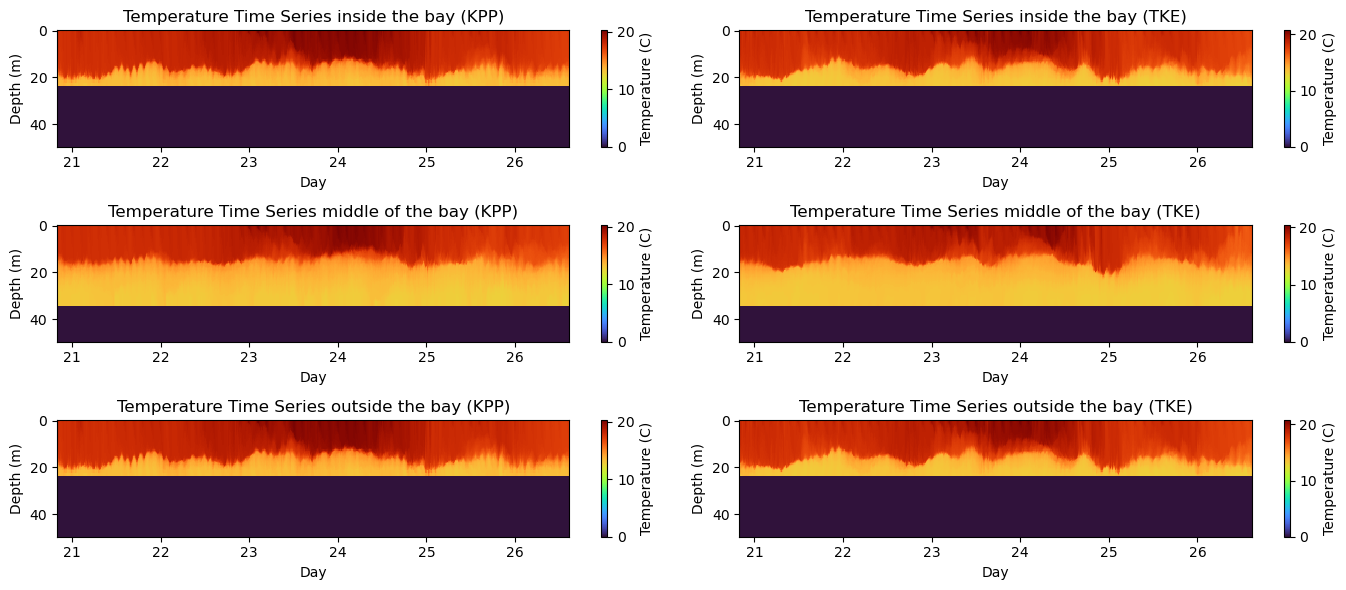

In [165]:
#temperature plots

plt.figure(figsize=(14,6))

plt.subplot(3,2,1)

#inside plots
C = plt.pcolormesh(time, depths, theta_in_matrix_kpp, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Time Series inside the bay (KPP)')


plt.subplot(3,2,2)
C = plt.pcolormesh(time, depths, theta_in_matrix_tke, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Time Series inside the bay (TKE)')

#middle plots
plt.subplot(3,2,3)
C = plt.pcolormesh(time, depths, theta_mid_matrix_kpp, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Time Series middle of the bay (KPP)')


plt.subplot(3,2,4)
C = plt.pcolormesh(time, depths, theta_mid_matrix_tke, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Time Series middle of the bay (TKE)')

#outside plots
plt.subplot(3,2,5)
C = plt.pcolormesh(time, depths, theta_out_matrix_kpp, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Time Series outside the bay (KPP)')


plt.subplot(3,2,6)
C = plt.pcolormesh(time, depths, theta_out_matrix_tke, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Time Series outside the bay (TKE)')

plt.tight_layout()
plt.show()

### Plot residuals for KPP and TKE temperature to visualize differences in temperature

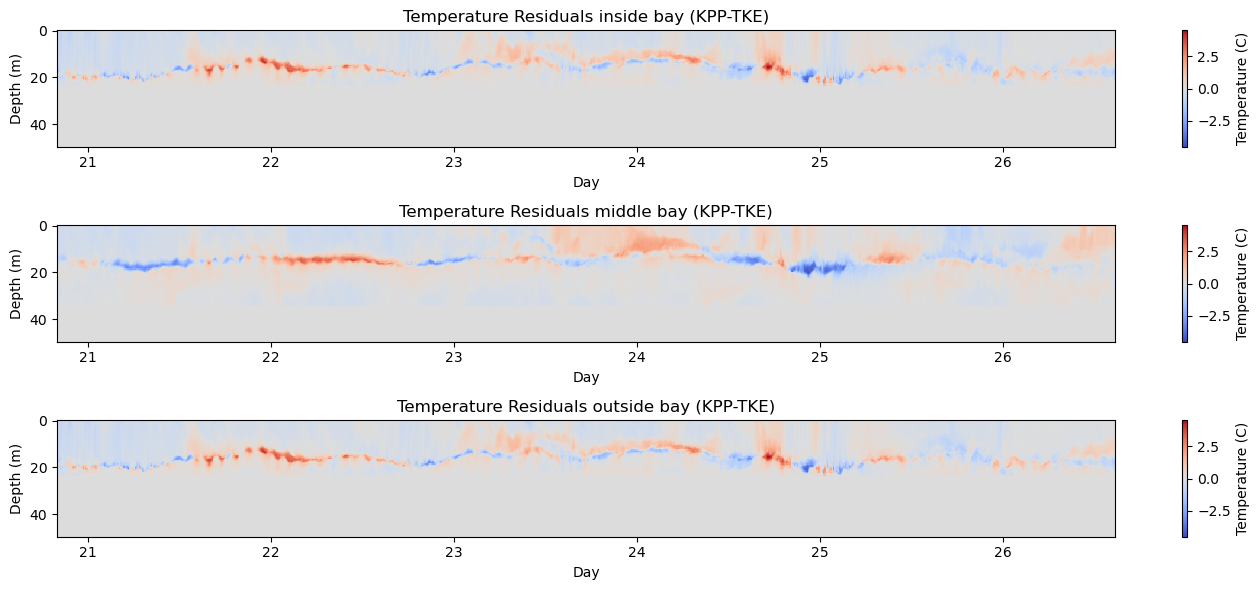

In [167]:
#find difference in tke and kpp theta magnitudes
in_theta_res = theta_in_matrix_kpp - theta_in_matrix_tke
mid_theta_res = theta_mid_matrix_kpp - theta_mid_matrix_tke
out_theta_res = theta_out_matrix_kpp - theta_out_matrix_tke

vmax = np.max(np.abs([in_theta_res, mid_theta_res, out_theta_res]))
vmin = -vmax

#plot residuals
plt.figure(figsize=(14,6))

plt.subplot(3,1,1)

C = plt.pcolormesh(time, depths, in_theta_res, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Residuals inside bay (KPP-TKE)')


plt.subplot(3,1,2)
C = plt.pcolormesh(time, depths, mid_theta_res, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Residuals middle bay (KPP-TKE)')

plt.subplot(3,1,3)
C = plt.pcolormesh(time, depths, out_theta_res, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.gca().invert_yaxis()  
plt.colorbar(C, label='Temperature (C)')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Temperature Residuals outside bay (KPP-TKE)')

plt.tight_layout()
plt.show()

Temperature from the KPP model seems to be slightly coolor at the surface compared to the TKE model. Lots of variation between the two models can be seen at around 20 m depth.

### Create Hovmoller plots for TKE and KPP eddy viscosity for our three points

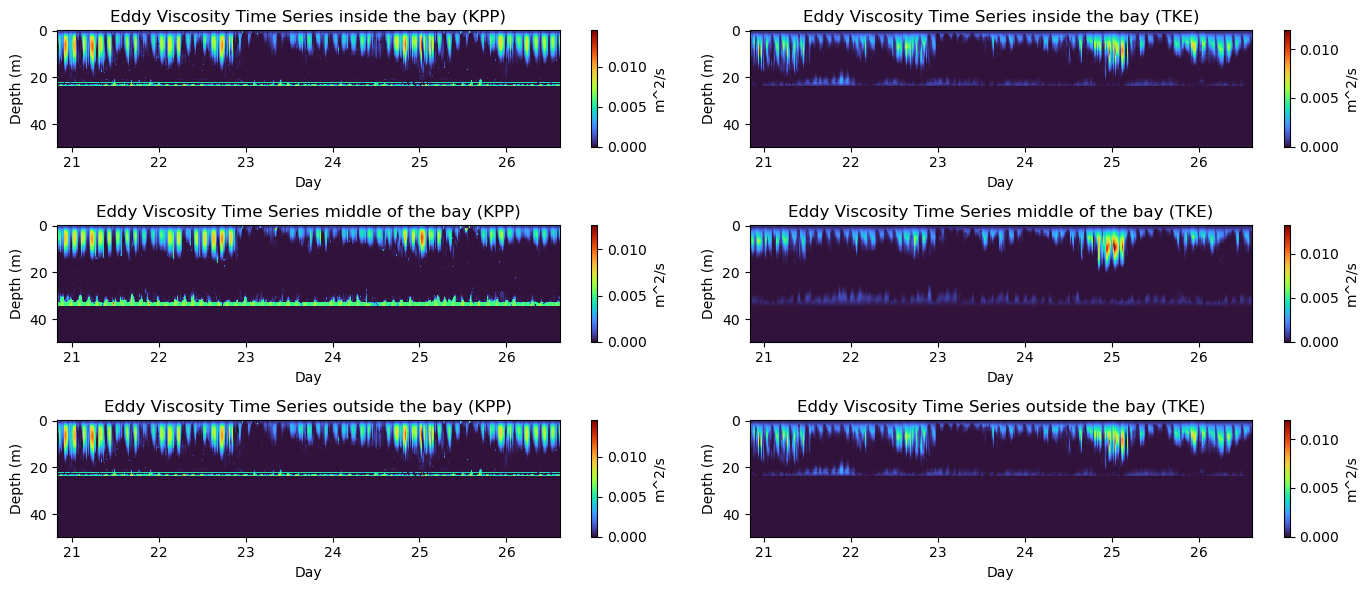

In [169]:
#eddy viscosity plots

plt.figure(figsize=(14,6))

#inside plots
plt.subplot(3,2,1)

C = plt.pcolormesh(time, depths, visc_in_matrix_kpp, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Time Series inside the bay (KPP)')


plt.subplot(3,2,2)
C = plt.pcolormesh(time, depths, visc_in_matrix_tke, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Time Series inside the bay (TKE)')

#middle plots
plt.subplot(3,2,3)
C = plt.pcolormesh(time, depths, visc_mid_matrix_kpp, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Time Series middle of the bay (KPP)')


plt.subplot(3,2,4)
C = plt.pcolormesh(time, depths, visc_mid_matrix_tke, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Time Series middle of the bay (TKE)')

#outside plots
plt.subplot(3,2,5)
C = plt.pcolormesh(time, depths, visc_out_matrix_kpp, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Time Series outside the bay (KPP)')


plt.subplot(3,2,6)
C = plt.pcolormesh(time, depths, visc_out_matrix_tke, cmap='turbo')

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Time Series outside the bay (TKE)')

plt.tight_layout()
plt.show()

### Plot residuals for KPP and TKE eddy viscosity to visualize differences in temperature

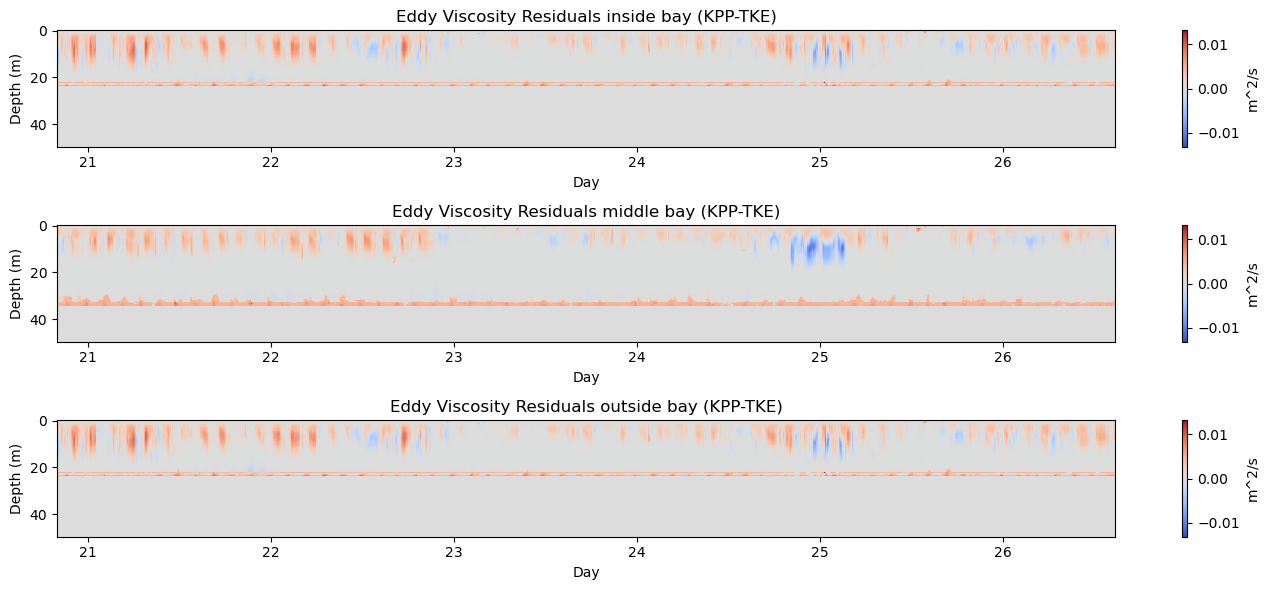

In [171]:
#find difference in tke and kpp eddy visc magnitudes
in_visc_res = visc_in_matrix_kpp - visc_in_matrix_tke
mid_visc_res = visc_mid_matrix_kpp - visc_mid_matrix_tke
out_visc_res = visc_out_matrix_kpp - visc_out_matrix_tke

vmax = np.max(np.abs([in_visc_res, mid_visc_res, out_visc_res]))
vmin = -vmax

#plot residuals
plt.figure(figsize=(14,6))

plt.subplot(3,1,1)

C = plt.pcolormesh(time, depths, in_visc_res, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Residuals inside bay (KPP-TKE)')


plt.subplot(3,1,2)
C = plt.pcolormesh(time, depths, mid_visc_res, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Residuals middle bay (KPP-TKE)')

plt.subplot(3,1,3)
C = plt.pcolormesh(time, depths, out_visc_res, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.gca().invert_yaxis()  
plt.colorbar(C, label='m^2/s')
plt.xlabel('Day')
plt.ylabel('Depth (m)')
plt.title('Eddy Viscosity Residuals outside bay (KPP-TKE)')

plt.tight_layout()
plt.show()

Eddy viscosity from the KPP model is consistently higher than the TKE model towards the surface and closer to the floor. This suggests that there is more mixing in the KPP model compared to the TKE model.

### Calculate timeseries for buoyancy frequency and eddy viscosity near the surface

In [193]:
#eddy viscosity
top5_idx = np.where(depths <= 5)[0]

# Compute mean over the top 5 meters
# For KPP
visc_mid_kpp_top5 = np.mean(visc_mid_matrix_kpp[top5_idx, :], axis=0)

# For TKE
visc_mid_tke_top5 = np.mean(visc_mid_matrix_tke[top5_idx, :], axis=0)


In [207]:
#buoyancy frequency
theta_mid_kpp_surface = theta_mid_matrix_kpp[1, :]
theta_mid_tke_surface = theta_mid_matrix_tke[1, :]
salt_mid_kpp_surface = salt_mid_matrix_kpp[1, :]
salt_mid_tke_surface = salt_mid_matrix_tke[1, :]

theta_mid_kpp_5m = theta_mid_matrix_kpp[10, :]
theta_mid_tke_5m = theta_mid_matrix_tke[10, :]
salt_mid_kpp_5m = salt_mid_matrix_kpp[10, :]
salt_mid_tke_5m = salt_mid_matrix_tke[10, :]


SP_TKE = np.array([salt_mid_tke_surface, salt_mid_tke_5m])
t_TKE  = np.array([theta_mid_tke_surface, theta_mid_tke_5m])

SP_KPP = np.array([salt_mid_kpp_surface, salt_mid_kpp_5m])
t_KPP  = np.array([theta_mid_kpp_surface, theta_mid_kpp_5m])
p = np.array([0.5, 5.0])

##next three lines are from chat gpt because I was really struggling with dimensions
p_2d = p[:, None]  

lon_mid = np.zeros((2, SP_TKE.shape[1]))  
lat_mid = np.zeros((2, SP_TKE.shape[1])) 

SA_TKE = gsw.SA_from_SP(SP_TKE, p[:, None], lon_mid, lat_mid)
CT_TKE = gsw.CT_from_pt(SA_TKE, t_TKE)

SA_KPP = gsw.SA_from_SP(SP_KPP, p[:, None], lon_mid, lat_mid)
CT_KPP = gsw.CT_from_pt(SA_KPP, t_KPP)

N2_TKE, p_mid_TKE = gsw.Nsquared(SA_TKE, CT_TKE, p_2d, axis=0)
N2_KPP, p_mid_KPP = gsw.Nsquared(SA_KPP, CT_KPP, p_2d, axis=0)


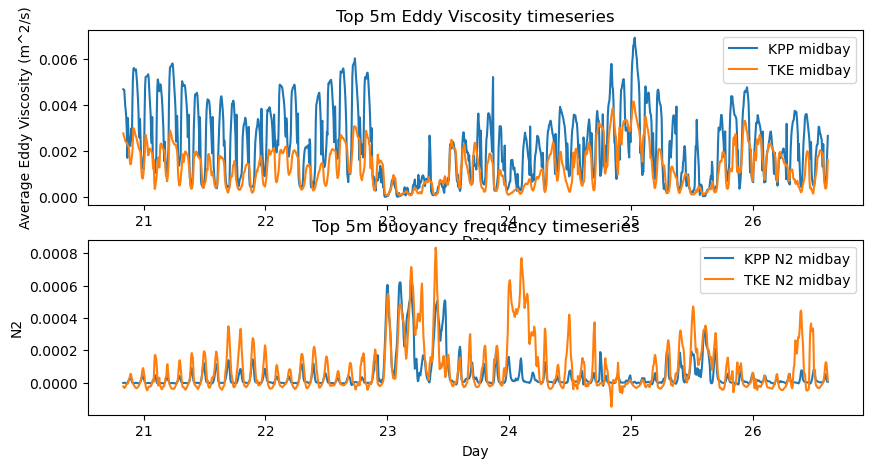

<Figure size 640x480 with 0 Axes>

In [217]:
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(time, visc_mid_kpp_top5, label='KPP midbay')
plt.plot(time, visc_mid_tke_top5, label='TKE midbay')

plt.xlabel('Day')
plt.ylabel('Average Eddy Viscosity (m^2/s)')
plt.title('Top 5m Eddy Viscosity timeseries')
plt.legend()


plt.subplot(2,1,2)
plt.plot(time, N2_KPP.flatten(), label='KPP N2 midbay')
plt.plot(time, N2_TKE.flatten(), label='TKE N2 midbay')

plt.xlabel('Day')
plt.ylabel('N2')
plt.title('Top 5m buoyancy frequency timeseries')
plt.legend()
plt.show()
plt.tight_layout()